In [1]:
###### PROBLEM 1:
###### An analysis of Suicied of Saul #######

In [2]:
%cd ..

/Users/gimli/projects/igre


In [3]:
import modalities.dir_dataset as dataset
import cv2
import matplotlib.pyplot as plt
import src.models.ig as ig
import src.data.rescale_range as rr
import numpy as np
import src.visualization.mimshow as mplot
import src.features.stats as stats
np.set_printoptions(suppress=True)

In [4]:
# Data load
detail, detail_metadata = dataset.load_all_images("/Users/gimli/Qsync/datasets/Suicide_Of_Saul/Detail_tif")
saul, saul_metadata = dataset.load_all_images("/Users/gimli/Qsync/datasets/Suicide_Of_Saul/total_per_tif")

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


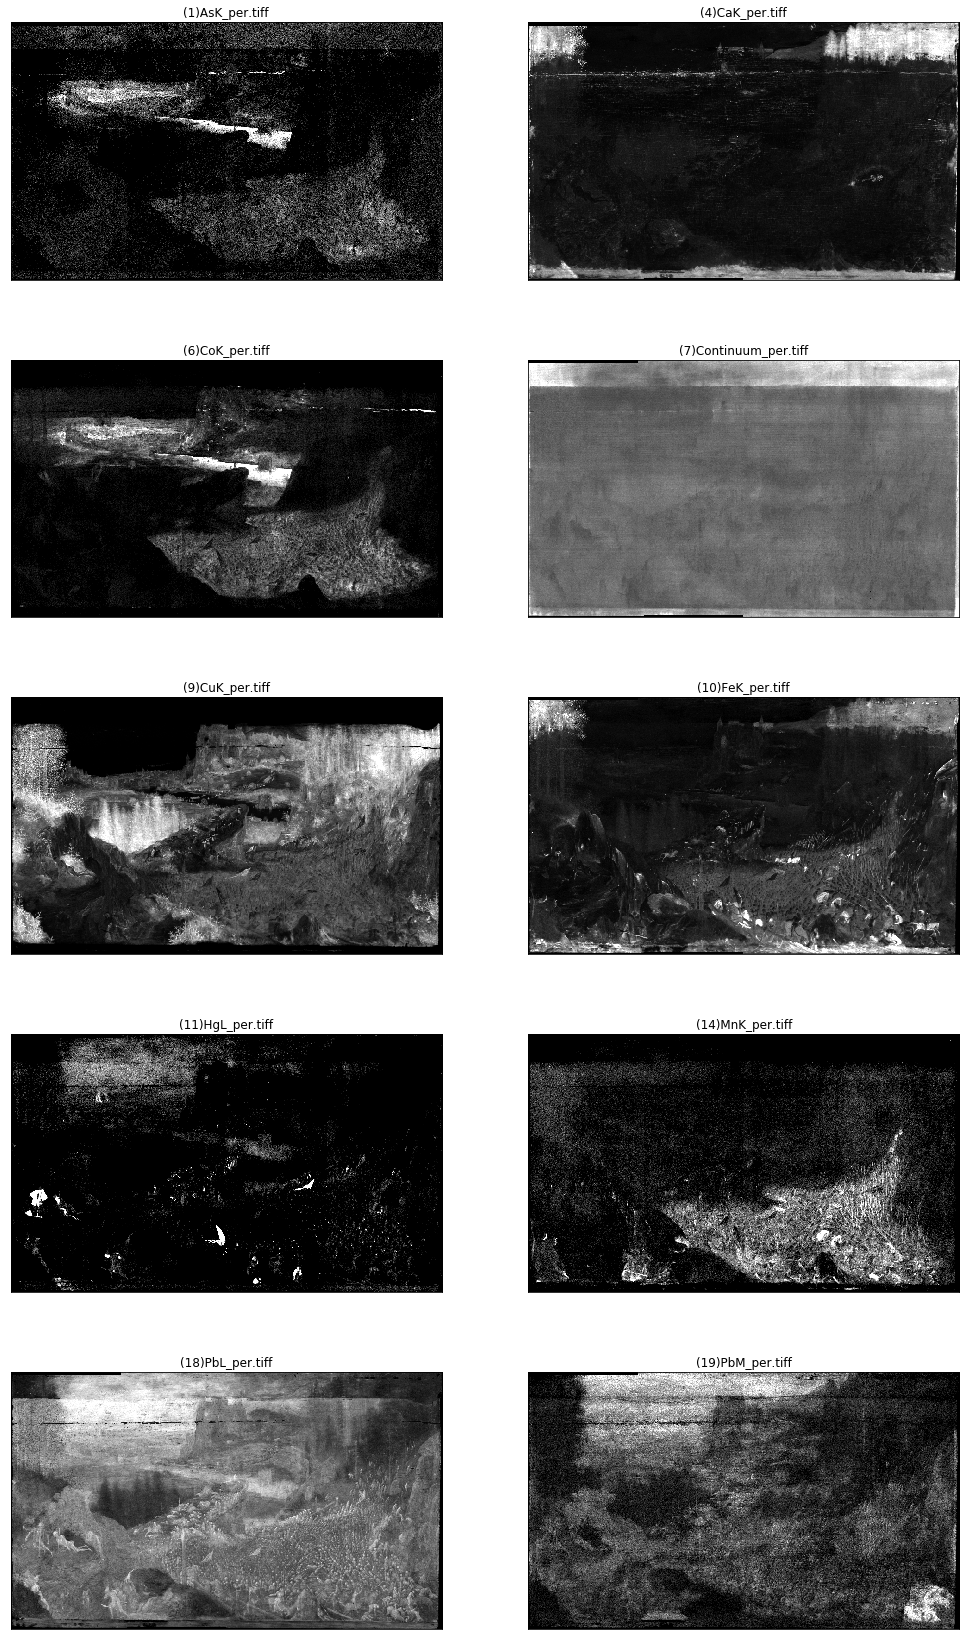

In [5]:
# An overview of relevant modalities
mplot.draw(saul, saul_metadata, [1,4,6,7,9,10,11,14,18,19])

In [6]:
# Manually registered visible image
vis = np.asarray(cv2.cvtColor(cv2.imread("/Users/gimli/Qsync/datasets/Suicide_Of_Saul/outputs/visw.png"),cv2.COLOR_BGR2HSV)).astype(np.float32)/255.0

In [7]:
######## Extrapolation from selected modalities into color HUE #########
diff, approx, model = ig.information_gain(saul[0][:,:,[1,4,6,7,9,10,11,14,18,19]], vis[:,:,0], layers=[250, 250, 250], training_set_size=500000)

Selecting 500000 samples randomly for use by algorithm.
Adding input layer, width = 10
Adding dense layer, width = 250
Instructions for updating:
Colocations handled automatically by placer.
Adding dense layer, width = 250
Adding dense layer, width = 250
Adding dense layer, width = 1
Instructions for updating:
Use tf.cast instead.
Compiling model took 0.1121's.
Train on 400000 samples, validate on 100000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
400000/400000 [==============================] - 52s 131us/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/10
400000/400000 [==============================] - 55s 136us/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/10
400000/400000 [==============================] - 52s 129us/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/10
400000

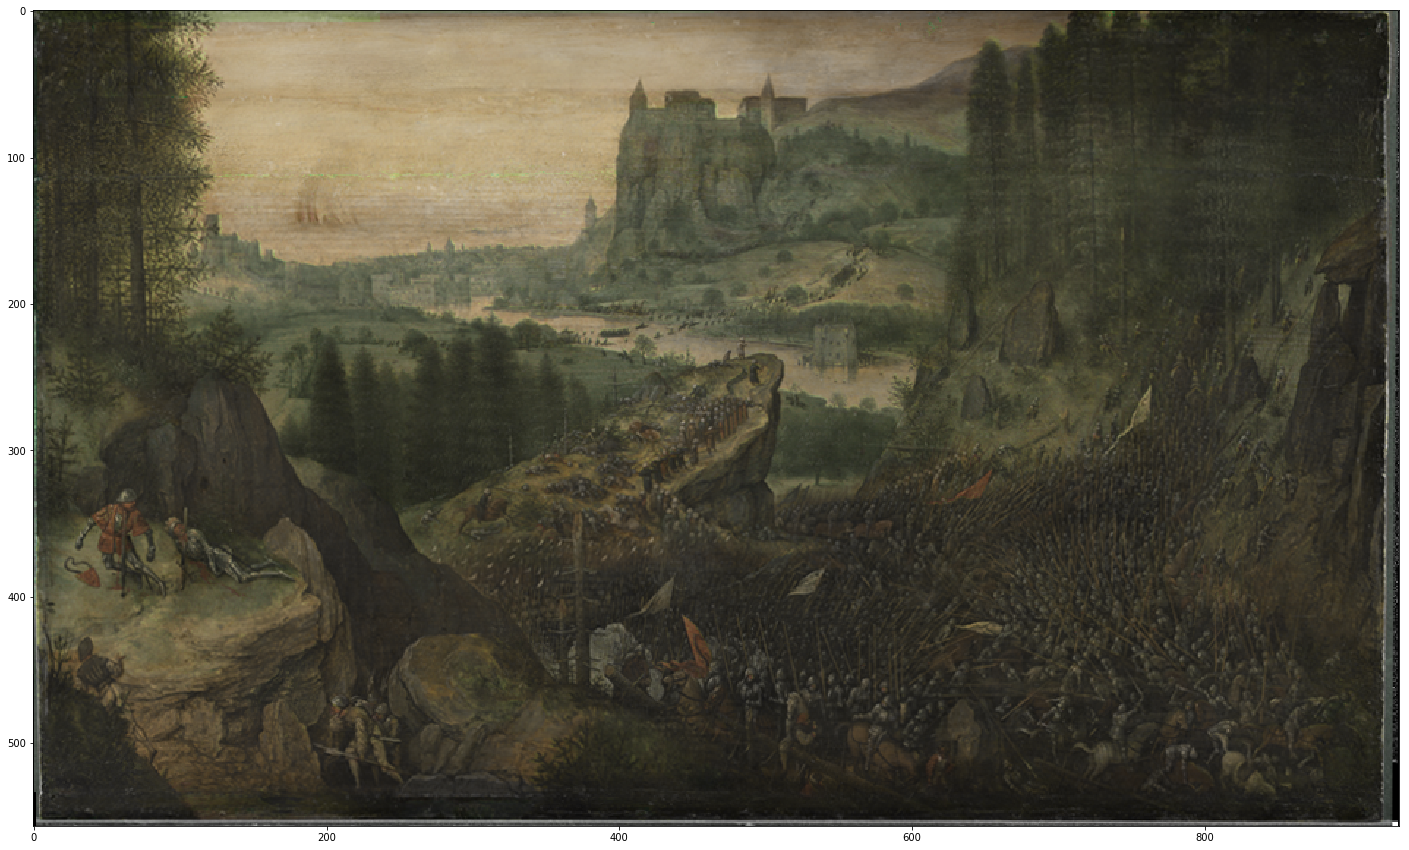

In [8]:
###### And now take a look how good extrapolation is ########
app = vis.copy()
app[:,:,0] = np.reshape(approx, (approx.shape[0], approx.shape[1], 1))[:,:,0]
plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor((app*255.0).astype(np.uint8), cv2.COLOR_HSV2RGB))

##### First glance: hue of colors is not good.

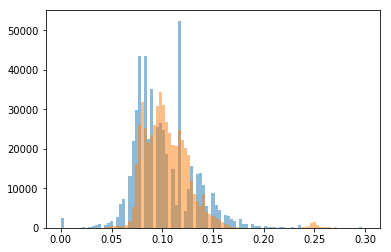

In [9]:
### Comparison of input HUEs distribution and extrapolated HUEs
bins = np.linspace(0, 0.3, 100)
plt.hist(np.reshape(vis[:,:,0], (vis.shape[0] * vis.shape[1], 1)), bins=bins, alpha=0.5)
plt.hist(np.reshape(approx, (vis.shape[0] * vis.shape[1], 1)), bins=bins, alpha=0.5)
plt.show()

### Hue distribution seems OK (but ... what is the orange blob at 0.25??)

In [10]:
### How the modalities correlation changes ... 
### compare source modalities with our "approximation" versus source modalities with original HUE
approx_corr = stats.correlation(np.concatenate([approx, saul[0][:,:,[1,4,6,7,9,10,11,14,18,19]]], axis=2))[0]
vis_corr = stats.correlation(np.concatenate([np.reshape(vis[:,:,0], (vis.shape[0], vis.shape[1], 1)), saul[0][:,:,[1,4,6,7,9,10,11,14,18,19]]], axis=2))[0]
(approx_corr / vis_corr)[1:]

### Here we see that correlation between our "approximation" is about twice higher than the original one.
### This means that "learning" was successful.

array([ 2.05827784,  3.76598241, 96.91594519,  1.86363806,  1.78811963,
        1.46590904,  1.81084244,  1.80628746,  1.85706544,  1.8905371 ])

In [11]:
# Dropout
ins = saul[0][:,:,[1,4,6,7,9,10,11,14,18,19]]
ins[ins<0.8] = 0

In [12]:
### Compute HUE just from one modality - what is the best predicted color?
_, _, dropout_model = ig.information_gain(ins, vis[:,:,0])

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 10
Adding dense layer, width = 25
Adding dense layer, width = 25
Adding dense layer, width = 1
Compiling model took 0.3657's.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 73us/sample - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/10
20000/20000 [==============================] - 1s 65us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 3/10
20000/20000 [==============================] - 1s 57us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
20000/20000 [==============================] - 1s 60us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 5/10
20000/20000 [==============================] - 1s 57us/

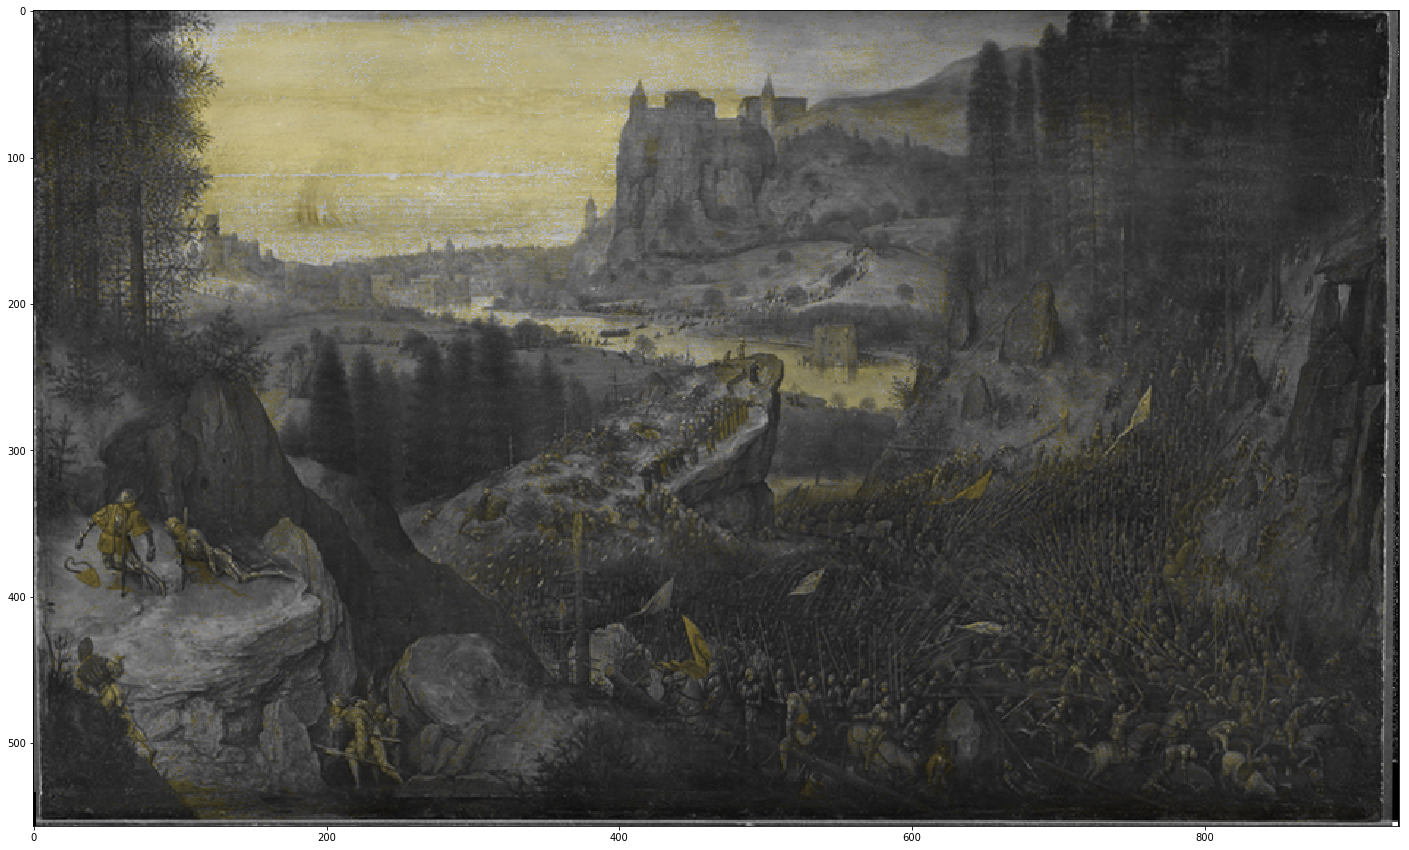

In [13]:
out = vis.copy()
modality = [11]
src = np.zeros(ins.shape)
for idx, value in enumerate(modality):
    src[:,:, idx] = saul[0][:,:,value]
out[:,:,0] = np.reshape(
    dropout_model.predict(np.reshape(src, (src.shape[0] * src.shape[1], src.shape[2]))), 
    (saul[0].shape[0], saul[0].shape[1], 1))[:,:,0]

out[np.sum(src, axis=2)==0,1] = 0

# And show the result
plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor((out*255.0).astype(np.uint8), cv2.COLOR_HSV2RGB))


In [14]:
# Time for notes:
# What we need is representation of XRF modalities in sense of VIS. This can be:
# - endmembers?
#    We have serveral modalities, most of them can be directly mapped to some color. 
#    * Let's try to find out which colors these are => max intensity => set of pixels => average hue
#    * Try to mix endmembers (ML) in such a way we obtain best reproduction
#    * Replace endmembers with more clean colors without fading and use ML model for reproduction
#    NOTE: Beware of clipping!!! Work just with HUE and SATURATION

0.8862745
0.63529414
0.74509805
0.6666667
0.8509804
0.7647059
0.6117647
0.9137255
0.7294118
0.88235295
0.73333335
0.5372549
0.7647059
0.83137256
0.7490196
0.8627451
0.75686276
0.7882353
0.91764706
0.84313726
0.79607844
0.7294118
0.7529412
0.22352941
0.7882353


([<matplotlib.axis.XTick at 0x13a4f7210>,
 <a list of 25 Text xticklabel objects>)

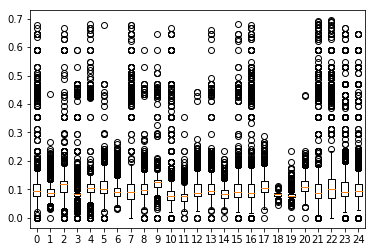

In [15]:
###### Look for endmembers ######
modalities = np.arange(25)
length = 10000
box = np.zeros((saul[0].shape[2],length))
for modality in modalities:
    xrf = np.reshape(saul[0][:,:,modality], (saul[0][:,:,modality].shape[0] * saul[0][:,:,modality].shape[1]))    
    hue = np.reshape(vis[:,:,0], (saul[0][:,:,modality].shape[0] * saul[0][:,:,modality].shape[1]))
    idxs = np.argsort(xrf)[-length:]
    print(np.min(xrf[idxs]))
    box[modality,:] = np.reshape(hue[idxs], length)    
plt.boxplot(box[modalities,:].T)
plt.xticks(np.arange(len(modalities))+1, modalities)


In [16]:
from scipy.spatial import ConvexHull

In [17]:
img = vis.copy()
border = 10
img[0:border,:,:] = 0
img[-border:,:,:] = 0
img[:,0:border,:] = 0
img[:,-border:,:] = 0
polar = np.reshape(img[:, :, [0,1]], (vis.shape[0]*vis.shape[1], 2))
theta = polar[:, 0] * 255 * 2 / 360 * 2 * np.pi # original range is {0-179}/255 we convert this into 0-2pi

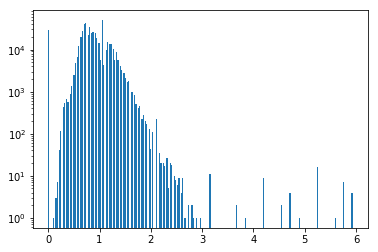

In [18]:
plt.hist(theta, bins=255)
plt.yscale('log')
plt.show()

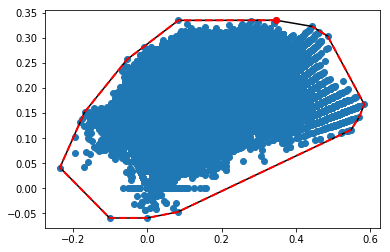

In [19]:
from scipy.spatial import ConvexHull
r = polar[:, 1]
points = np.zeros(polar.shape)
points[:, 0] = r * np.cos(theta)
points[:, 1] = r * np.sin(theta)
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

In [20]:
hull_hue = np.arctan(points[hull.vertices][:,1] / points[hull.vertices][:, 0])
hull_hue[hull_hue<0] = 2 * np.pi + hull_hue[hull_hue<0] # convert to positive numbers
hull_hue_orig = hull_hue / 2 / np.pi * 360 / 2 / 255 # conversion to original coords
saturation = np.sqrt(
    np.power(points[hull.vertices][:,1],2) 
    + np.power(points[hull.vertices][:,0],2)
)

In [21]:
endmembers = np.concatenate((
    np.reshape(hull_hue_orig, (hull_hue_orig.shape[0], 1)), 
    np.reshape(saturation, (hull_hue.shape[0], 1))), axis=1)
print(endmembers)

[[0.08627451 0.48235294]
 [0.14901961 0.34509804]
 [0.55294118 0.2627451 ]
 [0.62352941 0.22745097]
 [0.6862745  0.23921569]
 [0.05882353 0.11764706]
 [0.52941177 0.05882353]
 [0.64705886 0.09411765]
 [0.02352941 0.56078435]
 [0.02745098 0.58823532]
 [0.03137255 0.60784317]
 [0.06274511 0.57254906]
 [0.07058823 0.54901962]]


(13, 745, array([0.08627451, 0.48235294, 0.21960784], dtype=float32))
(11, 836, array([0.14901961, 0.34509805, 0.1254902 ], dtype=float32))
(545, 349, array([0.64705884, 0.09411765, 0.08235294], dtype=float32))
(545, 349, array([0.64705884, 0.09411765, 0.08235294], dtype=float32))
(545, 349, array([0.64705884, 0.09411765, 0.08235294], dtype=float32))
(61, 920, array([0.05882353, 0.11764706, 0.2       ], dtype=float32))
(543, 922, array([0.5294118 , 0.05882353, 0.27450982], dtype=float32))
(545, 349, array([0.64705884, 0.09411765, 0.08235294], dtype=float32))
(319, 845, array([0.02352941, 0.56078434, 0.35686275], dtype=float32))
(318, 650, array([0.02745098, 0.5882353 , 0.37254903], dtype=float32))
(351, 52, array([0.03137255, 0.60784316, 0.43137255], dtype=float32))
(465, 272, array([0.0627451 , 0.57254905, 0.43137255], dtype=float32))
(317, 365, array([0.07058824, 0.54901963, 0.47058824], dtype=float32))


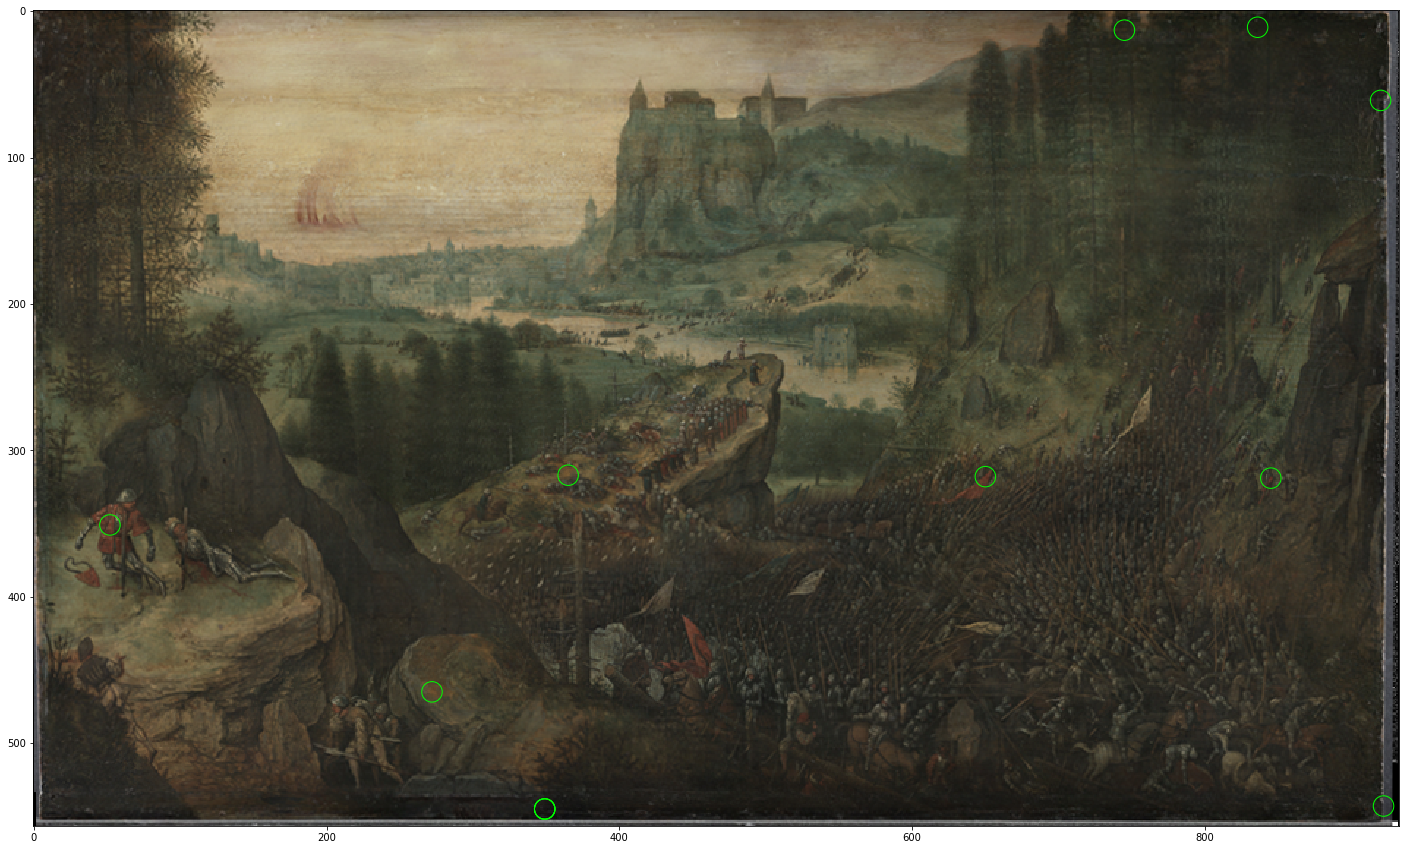

In [22]:
figure = plt.figure(figsize=(30,15))
ax = figure.add_subplot(1,1,1)
plt.imshow(cv2.cvtColor((vis * 255.0).astype(np.uint8), cv2.COLOR_HSV2RGB))
for endmember in endmembers:
    spot = np.argmin(np.sum(np.power(polar - endmember, 2), axis = 1))
    circ = plt.Circle((spot % vis.shape[1], spot // vis.shape[1]), 7, color="lime", fill=False)
    ax.add_patch(circ)
    print((spot // vis.shape[1], spot % vis.shape[1], vis[spot // vis.shape[1], spot % vis.shape[1], :]))
plt.show()

In [23]:
idx = np.unravel_index(np.argmax(vis[:,:,1].flatten()), vis[:,:,1].shape)
vis[idx[0], idx[1], :]

array([0.03137255, 0.60784316, 0.43137255], dtype=float32)

In [24]:
pwd

'/Users/gimli/projects/igre'